# Signal + Background Model (2D)
In this example a model made of a signal and a background is employed.
The fit is bidimensional in this example.

In [1]:
import mplhep
import numpy as np

import zfit

mplhep.style.use("LHCb2")
import matplotlib.pyplot as plt

/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


Model is created below

In [2]:
# create space
x = zfit.Space("x", limits=(-10, 10))
y = zfit.Space("y", limits=(-10, 10))
obs=(x,y)

In [3]:
# parameters
mu_x = zfit.Parameter("mu_x", 1.0, -4, 6)
sigma_x = zfit.Parameter("sigma_x", 1.0, 0.1, 10)
lambda_x = zfit.Parameter("lambda_x", -0.06, -1, -0.01)
mu_y = zfit.Parameter("mu_y", -1.0, -4, 6)
sigma_y = zfit.Parameter("sigma_y", 1.5, 0.1, 10)
lambda_y = zfit.Parameter("lambda_y", +0.02, -1, +1)
frac = zfit.Parameter("fraction", 0.3, 0, 1)

In [4]:
# model building, pdf creation
gauss_x = zfit.pdf.Gauss(mu=mu_x, sigma=sigma_x, obs=x)
exponential_x = zfit.pdf.Exponential(lambda_x, obs=x)
gauss_y = zfit.pdf.Gauss(mu=mu_y, sigma=sigma_y, obs=y)
exponential_y = zfit.pdf.Exponential(lambda_y, obs=y)
model = zfit.pdf.SumPDF([gauss_x * gauss_y, 
                         exponential_x * exponential_y], fracs=frac)

Data is generated from the above model by means of 
```python
data = model.create_sampler(nevs)
data.resample()
```

In [5]:
# data
n_sample = 10000
# exp_data = exponential.sample(n=n_sample * (1 - frac)).numpy()

# gauss_data = gauss.sample(n=n_sample * frac).numpy()

data = model.create_sampler(n_sample, limits=x*y)
data.resample()

In [6]:
# change values for showing the effect of the fit
mu_x.set_value(0.5)
sigma_x.set_value(1.2)
lambda_x.set_value(-0.05)
mu_y.set_value(0.5)
sigma_y.set_value(1.2)
lambda_y.set_value(-0.05)
frac.set_value(0.07)

Data and model before fitting are shown

(0.0, 1.0, 0.0, 1.0)

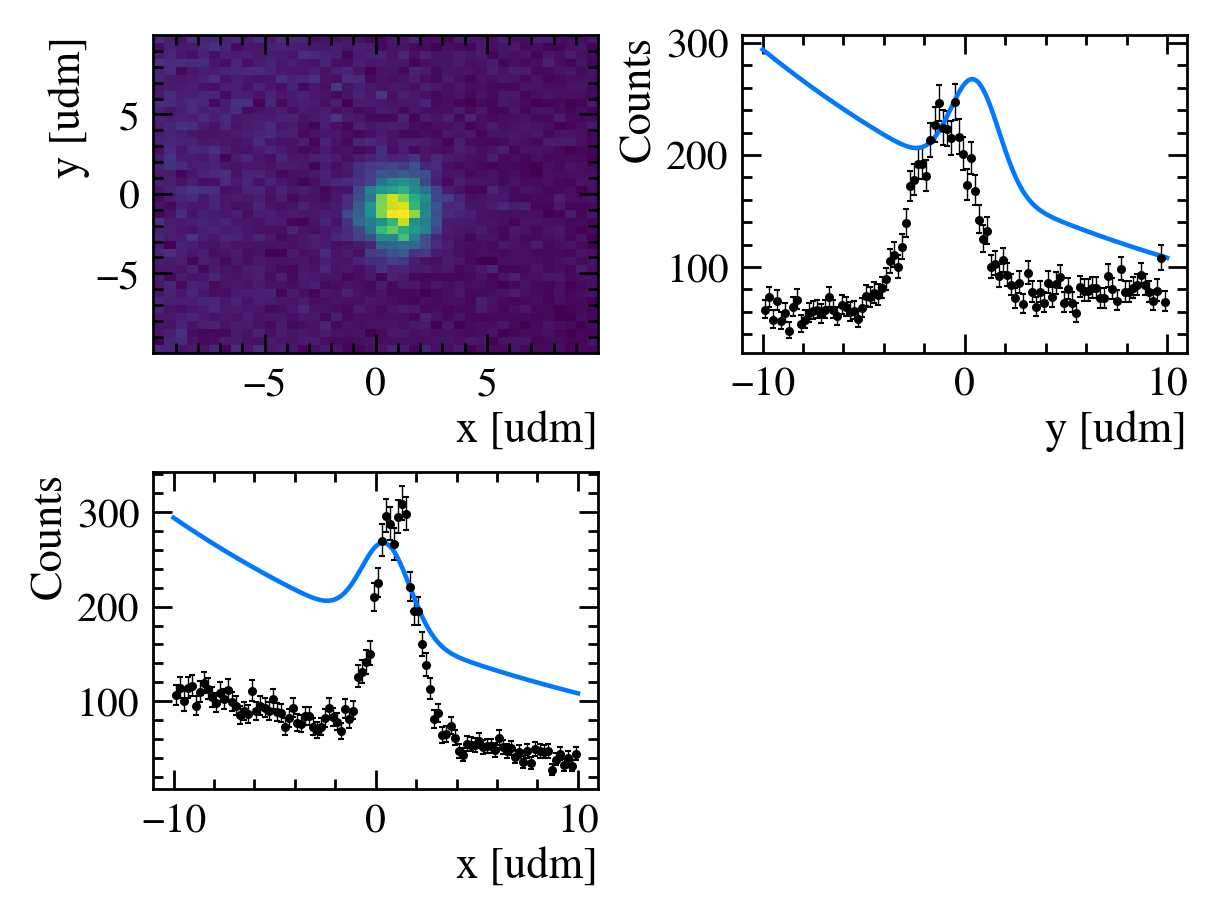

In [7]:
# plot the data
data_np = data.numpy()
n_bins = 50
fig, ax = plt.subplots(2,2)
ax[0][0].hist2d(data_np[:,0],data_np[:,1],bins=40)
ax[0][0].set_xlabel('x [udm]')
ax[0][0].set_ylabel('y [udm]')
# project the data on the x axis
mplhep.histplot(
        np.histogram(data_np[:,0], bins=100),
        yerr=True,
        color="black",
        histtype="errorbar",
        ax = ax[1][0]
    )
ax[1][0].set_ylabel("Counts")
ax[1][0].set_xlabel("x [udm]")
# overlay the model
x_pl = np.linspace(data_np[:,0].min(), data_np[:,0].max(), 1000)
y_pl = np.linspace(data_np[:,1].min(), data_np[:,1].max(), 1000)
x_model = model.create_projection_pdf(y).pdf(x_pl).numpy()
ax[1][0].plot(x_pl, x_model * data_np.size * 0.2)# NEED TO FIX SCALE FACTOR
# project the data on the y axis
mplhep.histplot(
        np.histogram(data_np[:,1], bins=100),
        yerr=True,
        color="black",
        histtype="errorbar",
        ax = ax[0][1]
    )
ax[0][1].set_ylabel("Counts")
ax[0][1].set_xlabel("y [udm]")
y_model = model.create_projection_pdf(x).pdf(y_pl).numpy() 
ax[0][1].plot(y_pl, y_model * data_np.size * 0.2)# NEED TO FIX SCALE FACTOR
# Turn off the axis for the subplot at position [1, 1] to make it completely blank
ax[1, 1].axis('off')

Run the fit

In [8]:
# create NLL
nll = zfit.loss.UnbinnedNLL(model=model, data=data)

# create a minimizer
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)

# do the error calculations, here with minos
param_errors, _ = result.errors()

/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1318: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(
/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1341: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.errors_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of errors (which is currently the method name such as `minuit_minos`or `zfit_errors`) has changed to `errors`. Old names are still added as well for compatibility but will be removed in the future. INSTRUCTIONS: to stay compatible, change wherever you access the error to 'errors' or specify the name expli

In [9]:
print(result)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_0, fraction]] data=[<zfit.core.data.Sampler object at 0x10501bc70>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 4.3e-05 │ -1756.679   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name        value  (rounded)               errors         minuit_minos    at limit
--------  ------------------  -------------------  -------------------  ----------
fraction            0.300637  - 0.0054   + 0.0054  - 0.0054   + 0.0054       False
mu_x                0.980457  -  0.022   +  0.022  -  0.022   +  0.022       False
sigma_x              1.02362  -  0.019   +  0.019  -  0.019   +  0.019       False
mu_y   

Make nicer plot

(0.0, 1.0, 0.0, 1.0)

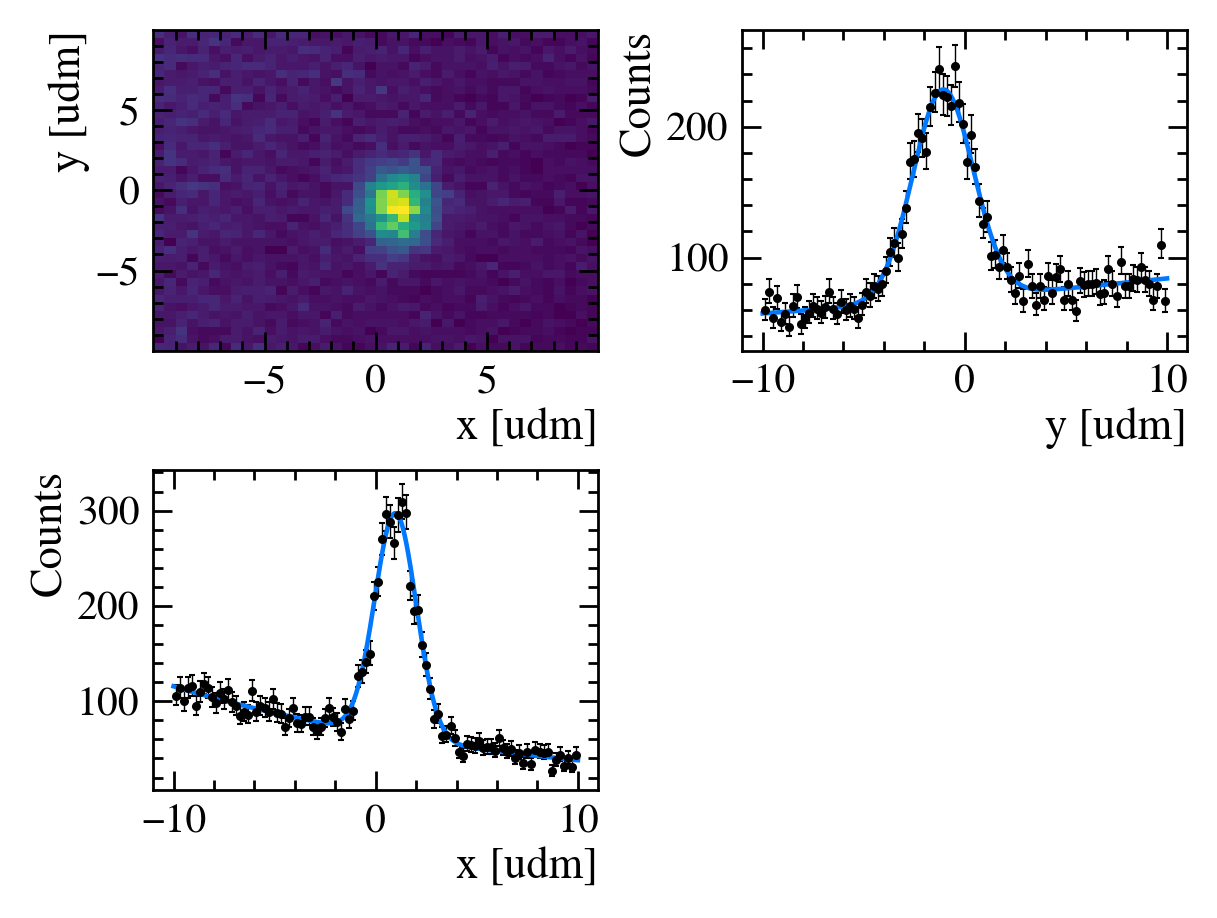

In [10]:
# plot the data
data_np = data.numpy()
n_bins = 100
fig, ax = plt.subplots(2,2)
ax[0][0].hist2d(data_np[:,0],data_np[:,1],bins=40)
ax[0][0].set_xlabel('x [udm]')
ax[0][0].set_ylabel('y [udm]')
# project the data on the x axis
mplhep.histplot(
        np.histogram(data_np[:,0], bins=n_bins, range = x.limit1d),
        yerr=True,
        color="black",
        histtype="errorbar",
        ax = ax[1][0]
    )
ax[1][0].set_ylabel("Counts")
ax[1][0].set_xlabel("x [udm]")
# overlay the model
x_pl = np.linspace(data_np[:,0].min(), data_np[:,0].max(), 1000)
y_pl = np.linspace(data_np[:,1].min(), data_np[:,1].max(), 1000)
x_model = model.create_projection_pdf(y).pdf(x_pl).numpy() 
ax[1][0].plot(x_pl, x_model * data_np.size / n_bins * (x.limit1d[1]-x.limit1d[0]) / 2) # NEED TO FIX SCALE FACTOR
# project the data on the y axis
mplhep.histplot(
        np.histogram(data_np[:,1], bins=n_bins, range = y.limit1d),
        yerr=True,
        color="black",
        histtype="errorbar",
        ax = ax[0][1]
    )
ax[0][1].set_ylabel("Counts")
ax[0][1].set_xlabel("y [udm]")
y_model = model.create_projection_pdf(x).pdf(y_pl).numpy() 
ax[0][1].plot(y_pl, y_model * data_np.size * 0.1) # NEED TO FIX SCALE FACTOR
# Turn off the axis for the subplot at position [1, 1] to make it completely blank
ax[1, 1].axis('off')

In [11]:
import os, sys
sys.path.append(f'{os.environ["PWD"]}/utilities')
from plotting import Plotter

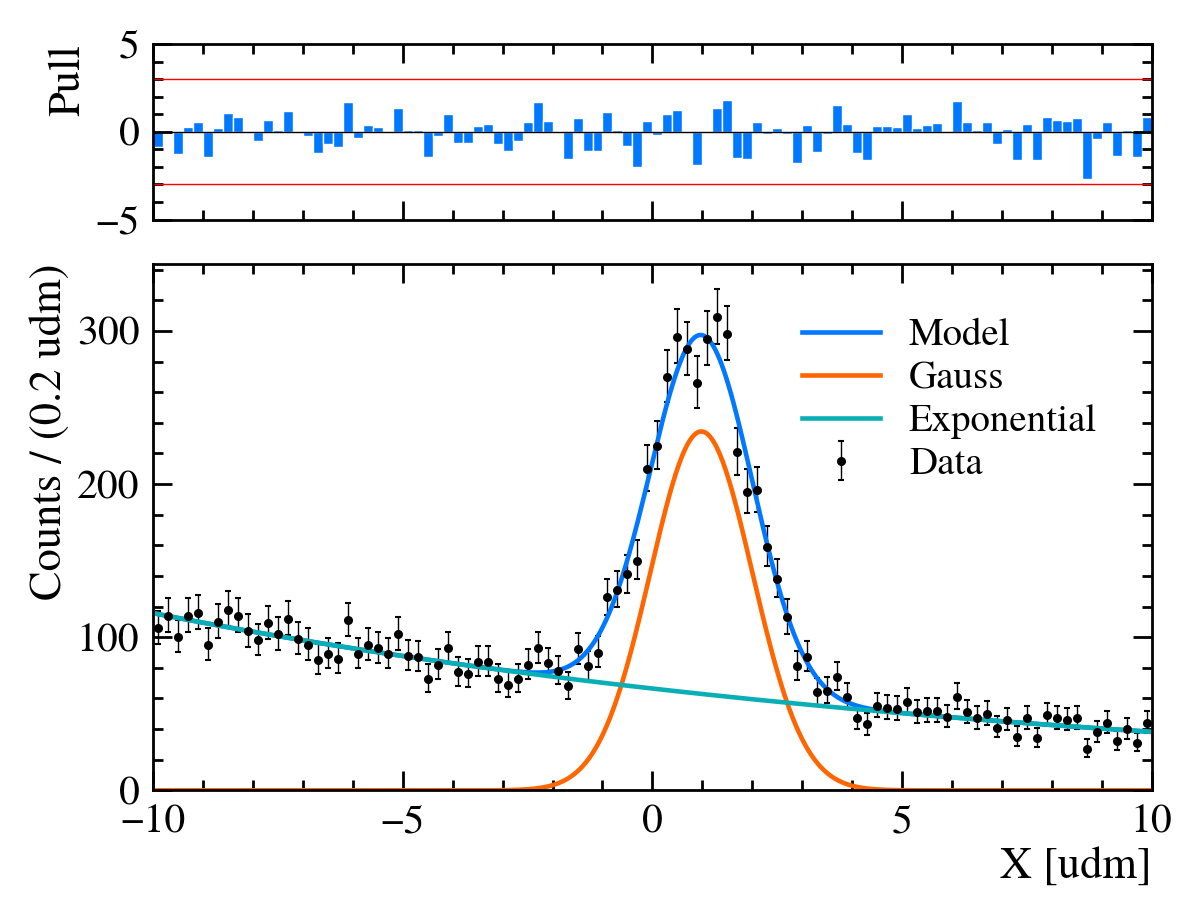

In [13]:
plotter = Plotter(data_np[:,0], model.create_projection_pdf(y), bins=100, range=x.limit1d, xlabel='X', xunit='udm')
plotter.add_component(gauss_x, frac, label='Gauss')
plotter.add_component(exponential_x, 1-frac, label='Exponential')
fig, axs = plotter.plot_fit_and_residuals()

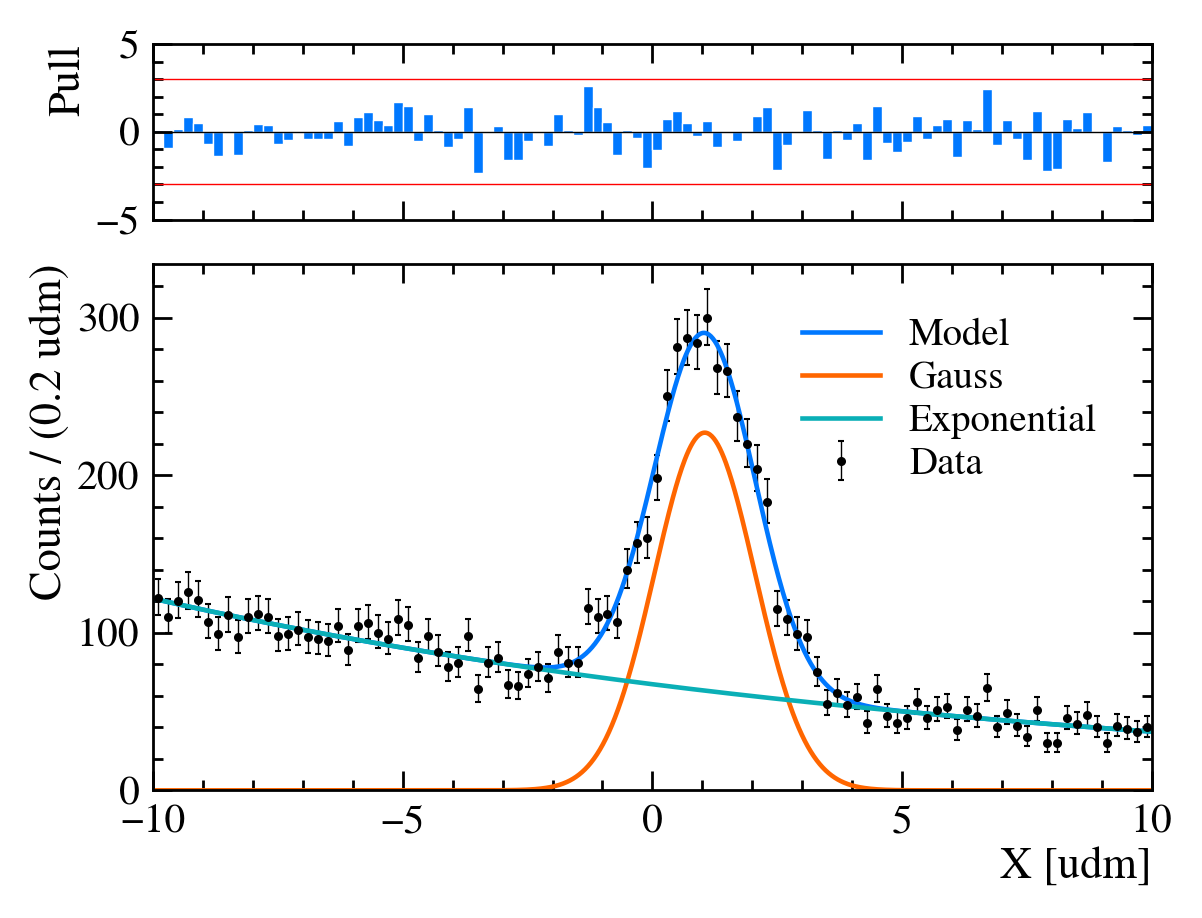

In [7]:
plotter = Plotter(data_np, model, bins=100, range=(-10,10), xlabel='X', xunit='udm')
plotter.add_component(gauss, frac, label='Gauss')
plotter.add_component(exponential, 1-frac, label='Exponential')
fig, axs = plotter.plot_fit_and_residuals()